In [1]:
# load data
import glob
import os

# computing
import numpy as np
import pandas as pd

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# feature extraction
import cv2
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer # https://realpython.com/k-means-clustering-python/

# modelling
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

# evalutaion
from sklearn.metrics import classification_report

# load/save model
import pickle

# Load Data

- input: -
- output: `X, y`

In [2]:
# ukurang gambar 224x224
def import_image(file) :
    image = cv2.imread(file)
    image = cv2.resize(image, (224, 224), interpolation = cv2.INTER_AREA)
    return image

def label_image(character, length) :
    array = np.full(length, character)
    return array

def import_data(character, path) :
    file_path = glob.glob(path)
    images = np.array([import_image(file) for file in file_path])
    label = label_image(character, len(file_path))
    
    return images, label

In [3]:
hanacaraka = ('ba','ca','da','dha','ga','ha','ja','ka','la','ma','na','nga','nya','pa','ra','sa','ta','tha','wa','ya')

X = np.empty((0, 224, 224, 3), np.uint8)
y = np.empty((0))


for character in hanacaraka:
    file_path = "../Dataset/vzrenggamani/" + character + "/*.png"
    
    X_temp, y_temp = import_data(character, file_path)
    
    print("Ukuran karakter", character, ":", len(X_temp))
    
    X = np.append(X, X_temp, axis=0)
    y = np.append(y, y_temp, axis=0)

Ukuran karakter ba : 79
Ukuran karakter ca : 79
Ukuran karakter da : 79
Ukuran karakter dha : 77
Ukuran karakter ga : 78
Ukuran karakter ha : 78
Ukuran karakter ja : 78
Ukuran karakter ka : 79
Ukuran karakter la : 78
Ukuran karakter ma : 79
Ukuran karakter na : 79
Ukuran karakter nga : 79
Ukuran karakter nya : 78
Ukuran karakter pa : 77
Ukuran karakter ra : 75
Ukuran karakter sa : 79
Ukuran karakter ta : 76
Ukuran karakter tha : 77
Ukuran karakter wa : 79
Ukuran karakter ya : 79


In [4]:
# Ukuran keseluruhan data
print("Ukuran data:", X.shape[0])

Ukuran data: 1562


<AxesSubplot:ylabel='count'>

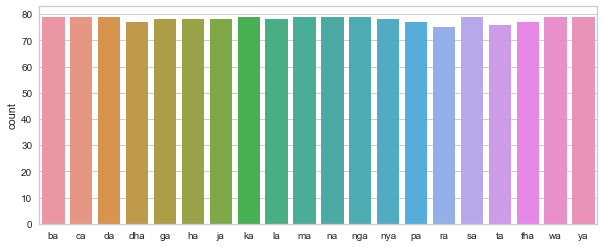

In [5]:
plt.figure(figsize=(10,4))
sns.countplot(x=y)

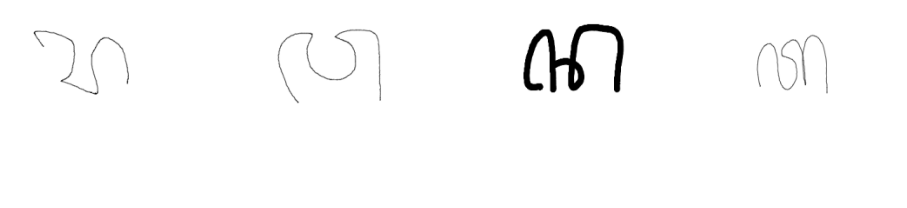

In [8]:
np.random.seed(42)

fig = plt.figure(figsize=(16, 4))
columns = 4
rows = 1
for i in range(1, columns*rows + 1):
    img = np.array(X[np.random.randint(0, X.shape[0]), 0:])
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.axis('off')

plt.show()

# Preprocessing

- input: `X`
- output: `X_prep`

kind of image preprocessing
- grayscaling (o)
- resizing (x)
- cropping (x)
- binarization (o)
- negative (x)
- skeletonization/thinning (o)
- noise reduction (x)
- sharpening (o)

In [20]:
def grayscaling(image):
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    return image
    
def thresholding(image, th):
    ret, image = cv2.threshold(image, th, 255, cv2.THRESH_BINARY)
    return image

def resizing(image, size):
    image = cv2.resize(image, (size, size), interpolation = cv2.INTER_AREA)
    return image

# https://soumyapatilblogs.medium.com/image-filtering-using-opencv-66b67e1bd968
def denoising(image):
    image = cv2.medianBlur(image, 5)
    return image

def sharpening(image):
    kernel = np.array([[0, -1, 0], [-1, 5,-1], [0, -1, 0]])
    #kernel = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])
    image = cv2.filter2D(src=image, ddepth=-1, kernel=kernel)
    return image

def edge_detecting(image):
    if (image.ndim == 3):
        image = grayscaling(image)
    #image = cv2.GaussianBlur(image, (3,3), 0)
    image = cv2.Canny(image=image, threshold1=100, threshold2=200)
    return image

def equalizing(image):
    if (image.ndim == 3):
        b, g, r = cv2.split(image)
        red = cv2.equalizeHist(r)
        green = cv2.equalizeHist(g)
        blue = cv2.equalizeHist(b)
        image = cv2.merge((blue, green, red))
    else:
        image = cv2.equalizeHist(image)
    return image

def boundary_detecting(image_canny):
    x_start, x_end, y_start, y_end = 0, 223, 0, 223
    for i in range(image_canny.shape[0]):
        if(image_canny[i].max() > 240):
            x_start = i - 10
            if(x_start < 0):
                x_start = 0
            break

    for i in range(image_canny.shape[0]-1, 0, -1):
        if(image_canny[i].max() > 240):
            x_end = i + 10
            if(x_end > 255):
                x_end = 255
            break

    for i in range(image_canny.shape[1]):
        if(image_canny[:, i].max() > 240):
            y_start = i - 10
            if(y_start < 0):
                y_start = 0
            break

    for i in range(image_canny.shape[1]-1, 0, -1):
        if(image_canny[:, i].max() > 240):
            y_end = i + 10
            if(y_end > 255):
                y_end = 255
            break

    return x_start, x_end, y_start, y_end

def boundary_cropping(image):
    image_canny = edge_detecting(image)
    x_start, x_end, y_start, y_end = boundary_detecting(image_canny)
    image = image[x_start:x_end, y_start:y_end]
    return image

In [132]:
def preprocessing(image, size=192):
    image = resizing(image, size)
    image = equalizing(image)
    return image

In [133]:
X_prep = []

for i in range(X.shape[0]) :
    X_prep.append(preprocessing(X[i]))
    
X_prep = np.array(X_prep, dtype=np.uint8)

In [134]:
print("Dimensi data:", X_prep.shape)

Dimensi data: (1562, 192, 192)


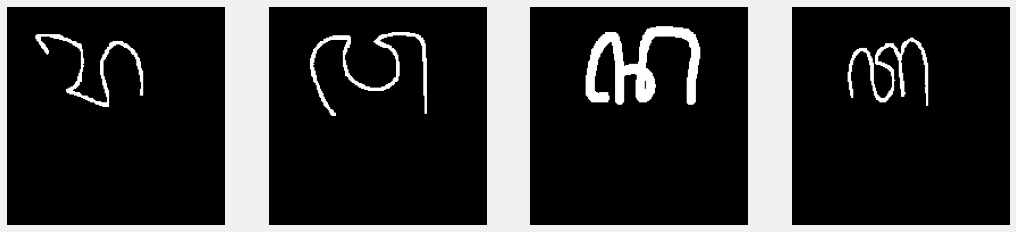

In [135]:
np.random.seed(42)

fig = plt.figure(figsize=(16, 4))
columns = 4
rows = 1
for i in range(1, columns*rows + 1):
    img = np.array(X_prep[np.random.randint(0, X.shape[0]), 0:])
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.axis('off')

plt.show()

# Feature Extraction

- input: `X_prep`
- output: `X_feature`

### Extract sift descriptors 

In [136]:
def extract_sift_features(list_image):

    image_descriptors = []
    sift = cv2.SIFT_create()
    for image in list_image:
        _, descriptor = sift.detectAndCompute(image, None)
        image_descriptors.append(descriptor)

    return image_descriptors

def split_all_descriptors(image_descriptors):
    all_descriptors = []
    for descriptor in image_descriptors:
        if descriptor is not None:
            for des in descriptor:
                all_descriptors.append(des)
    
    return np.array(all_descriptors)

In [137]:
image_descriptors = extract_sift_features(X_prep)
all_descriptors = split_all_descriptors(image_descriptors)

In [138]:
all_descriptors.shape

(77192, 128)

### Create bow of descriptor using cluster

In [104]:
ks = [100, 130, 160, 200, 240]
sse = []
silhouette_coefficients = []

for k in ks:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(all_descriptors)     
    sse.append(kmeans.inertia_)
    score = silhouette_score(all_descriptors, kmeans.labels_)
    silhouette_coefficients.append(score)
    print("Nilai k =", k, "(done)")

Nilai k = 100 (done)
Nilai k = 130 (done)
Nilai k = 160 (done)
Nilai k = 200 (done)
Nilai k = 240 (done)


Text(0, 0.5, 'Silhouette Coefficient')

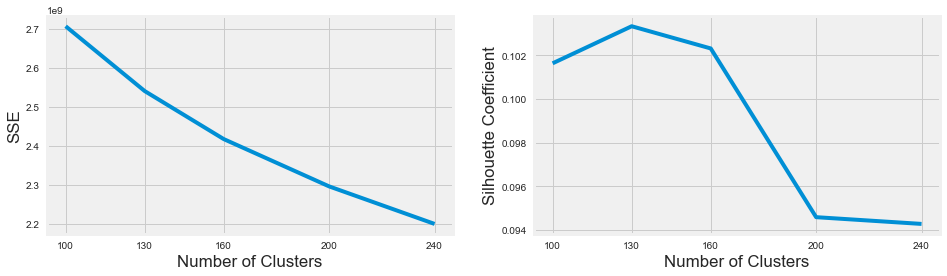

In [105]:
fig = plt.figure(figsize=(16, 4))
plt.style.use("fivethirtyeight")

fig.add_subplot(1, 2, 1)
plt.plot(ks, sse)
plt.xticks(ks)
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")

fig.add_subplot(1, 2, 2)
plt.plot(ks, silhouette_coefficients)
plt.xticks(ks)
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")

In [139]:
def kmeans_bow(all_descriptors, num_cluster):
    kmeans = KMeans(n_clusters = num_cluster, verbose=1, n_init=8)
    kmeans.fit(all_descriptors)

    bow_dict = kmeans.cluster_centers_

    #if not os.path.isfile('bow_dictionary.pkl'):
    pickle.dump(bow_dict, open('bow_dictionary.pkl', 'wb'))

    return kmeans, bow_dict

In [140]:
num_cluster = 200
kmeans, bow = kmeans_bow(all_descriptors, num_cluster)

Initialization complete
Iteration 0, inertia 3264358144.0
Iteration 1, inertia 2427570176.0
Iteration 2, inertia 2372110592.0
Iteration 3, inertia 2351521792.0
Iteration 4, inertia 2340371968.0
Iteration 5, inertia 2332636928.0
Iteration 6, inertia 2326925568.0
Iteration 7, inertia 2322324480.0
Iteration 8, inertia 2318462720.0
Iteration 9, inertia 2315410688.0
Iteration 10, inertia 2312960000.0
Iteration 11, inertia 2311198720.0
Iteration 12, inertia 2309800192.0
Iteration 13, inertia 2308574208.0
Iteration 14, inertia 2307610880.0
Iteration 15, inertia 2306772992.0
Iteration 16, inertia 2306011648.0
Iteration 17, inertia 2305302272.0
Iteration 18, inertia 2304668928.0
Iteration 19, inertia 2304094464.0
Iteration 20, inertia 2303522560.0
Iteration 21, inertia 2302928384.0
Iteration 22, inertia 2302352896.0
Iteration 23, inertia 2301867008.0
Iteration 24, inertia 2301458432.0
Iteration 25, inertia 2301068032.0
Iteration 26, inertia 2300730112.0
Iteration 27, inertia 2300446720.0
Iterat

Iteration 99, inertia 2296940800.0
Iteration 100, inertia 2296937472.0
Iteration 101, inertia 2296935936.0
Iteration 102, inertia 2296934656.0
Iteration 103, inertia 2296932352.0
Iteration 104, inertia 2296931840.0
Iteration 105, inertia 2296930048.0
Iteration 106, inertia 2296929024.0
Iteration 107, inertia 2296927744.0
Iteration 108, inertia 2296928000.0
Iteration 109, inertia 2296926976.0
Iteration 110, inertia 2296926464.0
Iteration 111, inertia 2296925184.0
Iteration 112, inertia 2296924672.0
Iteration 113, inertia 2296924416.0
Iteration 114, inertia 2296924416.0
Iteration 115, inertia 2296924160.0
Iteration 116, inertia 2296923136.0
Iteration 117, inertia 2296923392.0
Iteration 118, inertia 2296922112.0
Iteration 119, inertia 2296921600.0
Iteration 120, inertia 2296921088.0
Iteration 121, inertia 2296920832.0
Iteration 122, inertia 2296921088.0
Converged at iteration 122: strict convergence.
Initialization complete
Iteration 0, inertia 3254105856.0
Iteration 1, inertia 2445811712

Iteration 55, inertia 2298871808.0
Iteration 56, inertia 2298854656.0
Iteration 57, inertia 2298841600.0
Iteration 58, inertia 2298830336.0
Iteration 59, inertia 2298817536.0
Iteration 60, inertia 2298801408.0
Iteration 61, inertia 2298786560.0
Iteration 62, inertia 2298771968.0
Iteration 63, inertia 2298761216.0
Iteration 64, inertia 2298752256.0
Iteration 65, inertia 2298746624.0
Iteration 66, inertia 2298740736.0
Iteration 67, inertia 2298734080.0
Iteration 68, inertia 2298729984.0
Iteration 69, inertia 2298729216.0
Iteration 70, inertia 2298727936.0
Iteration 71, inertia 2298727680.0
Iteration 72, inertia 2298726912.0
Iteration 73, inertia 2298726912.0
Iteration 74, inertia 2298725888.0
Iteration 75, inertia 2298724352.0
Iteration 76, inertia 2298722304.0
Iteration 77, inertia 2298719488.0
Iteration 78, inertia 2298719232.0
Iteration 79, inertia 2298718464.0
Iteration 80, inertia 2298717952.0
Iteration 81, inertia 2298717440.0
Iteration 82, inertia 2298715904.0
Iteration 83, inerti

Iteration 68, inertia 2300365312.0
Iteration 69, inertia 2300321792.0
Iteration 70, inertia 2300280576.0
Iteration 71, inertia 2300255488.0
Iteration 72, inertia 2300214016.0
Iteration 73, inertia 2300160000.0
Iteration 74, inertia 2300112384.0
Iteration 75, inertia 2300068096.0
Iteration 76, inertia 2300048640.0
Iteration 77, inertia 2300033792.0
Iteration 78, inertia 2300017920.0
Iteration 79, inertia 2299988736.0
Iteration 80, inertia 2299971584.0
Iteration 81, inertia 2299959808.0
Iteration 82, inertia 2299945216.0
Iteration 83, inertia 2299931392.0
Iteration 84, inertia 2299920640.0
Iteration 85, inertia 2299905024.0
Iteration 86, inertia 2299890688.0
Iteration 87, inertia 2299881728.0
Iteration 88, inertia 2299873792.0
Iteration 89, inertia 2299863296.0
Iteration 90, inertia 2299855616.0
Iteration 91, inertia 2299846912.0
Iteration 92, inertia 2299835648.0
Iteration 93, inertia 2299830272.0
Iteration 94, inertia 2299825408.0
Iteration 95, inertia 2299823104.0
Iteration 96, inerti

Iteration 75, inertia 2298871552.0
Iteration 76, inertia 2298862592.0
Iteration 77, inertia 2298851328.0
Iteration 78, inertia 2298840832.0
Iteration 79, inertia 2298829568.0
Iteration 80, inertia 2298824192.0
Iteration 81, inertia 2298818816.0
Iteration 82, inertia 2298812672.0
Iteration 83, inertia 2298804736.0
Iteration 84, inertia 2298799872.0
Iteration 85, inertia 2298797056.0
Iteration 86, inertia 2298795008.0
Iteration 87, inertia 2298792960.0
Iteration 88, inertia 2298790912.0
Iteration 89, inertia 2298788352.0
Iteration 90, inertia 2298785536.0
Iteration 91, inertia 2298783232.0
Iteration 92, inertia 2298780928.0
Iteration 93, inertia 2298780672.0
Iteration 94, inertia 2298779392.0
Iteration 95, inertia 2298777856.0
Iteration 96, inertia 2298776832.0
Iteration 97, inertia 2298775808.0
Iteration 98, inertia 2298774528.0
Iteration 99, inertia 2298773760.0
Iteration 100, inertia 2298773248.0
Iteration 101, inertia 2298772992.0
Iteration 102, inertia 2298771712.0
Iteration 103, in

### Create features from bow

In [141]:
def create_feature_bow(image_descriptors, bow, num_cluster):
    X_features = []

    for i in range(len(image_descriptors)):
        features = np.array([0] * num_cluster, dtype=float)

        if image_descriptors[i] is not None:
            distance = cdist(image_descriptors[i], bow)
            argmin = np.argmin(distance, axis = 1)

            for j in argmin:
                features[j] += 1.0
        X_features.append(features)

    return np.array(X_features)

In [142]:
X_feature = create_feature_bow(image_descriptors, bow, num_cluster)

print("Dimensi data fitur:", X_feature.shape)

Dimensi data fitur: (1562, 200)


# Classification

- input: `X_feature, y`
- output: -

In [143]:
# normalization
scaler = StandardScaler().fit(X_feature)
X_scale = scaler.transform(X_feature)

In [144]:
# splitting data
X_train, X_test, y_train, y_test = train_test_split(X_scale, y, test_size=0.15, random_state=42)

print("Ukuran data training:", X_train.shape[0])
print("Ukuran data testing:", X_test.shape[0])

Ukuran data training: 1327
Ukuran data testing: 235


## KNN

In [145]:
knn_params = {'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19]}
knn_cv = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=knn_params, cv=5, verbose=3)

In [146]:
knn_cv.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END .....................n_neighbors=1;, score=0.139 total time=   0.0s
[CV 2/5] END .....................n_neighbors=1;, score=0.139 total time=   0.0s
[CV 3/5] END .....................n_neighbors=1;, score=0.125 total time=   0.0s
[CV 4/5] END .....................n_neighbors=1;, score=0.109 total time=   0.0s
[CV 5/5] END .....................n_neighbors=1;, score=0.125 total time=   0.0s
[CV 1/5] END .....................n_neighbors=3;, score=0.128 total time=   0.0s
[CV 2/5] END .....................n_neighbors=3;, score=0.150 total time=   0.0s
[CV 3/5] END .....................n_neighbors=3;, score=0.128 total time=   0.0s
[CV 4/5] END .....................n_neighbors=3;, score=0.117 total time=   0.0s
[CV 5/5] END .....................n_neighbors=3;, score=0.125 total time=   0.0s
[CV 1/5] END .....................n_neighbors=5;, score=0.124 total time=   0.0s
[CV 2/5] END .....................n_neighbors=5;

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19]},
             verbose=3)

In [147]:
print("Model terbaik:", knn_cv.best_estimator_)
print("Score terbaik:", knn_cv.best_score_)

Model terbaik: KNeighborsClassifier(n_neighbors=3)
Score terbaik: 0.1296013618953043


In [148]:
cv_results_df = pd.DataFrame(knn_cv.cv_results_)
cv_results_df = cv_results_df.sort_values(by=['rank_test_score'])
cv_results_df = (
    cv_results_df
    .set_index(cv_results_df["params"].apply(
        lambda x: "_".join(str(val) for val in x.values()))
    )
    .rename_axis('kernel')
)
cv_results_df[
    ['params', 'rank_test_score', 'mean_test_score', 'std_test_score']
]

,params,rank_test_score,mean_test_score,std_test_score
kernel,,,,
3,{'n_neighbors': 3},1,0.129601,0.011149
1,{'n_neighbors': 1},2,0.127337,0.011072
7,{'n_neighbors': 7},3,0.113764,0.017388
5,{'n_neighbors': 5},4,0.113012,0.017510
9,{'n_neighbors': 9},5,0.112240,0.027731
11,{'n_neighbors': 11},6,0.103223,0.019213
15,{'n_neighbors': 15},7,0.100953,0.021366
13,{'n_neighbors': 13},8,0.100207,0.016659
17,{'n_neighbors': 17},9,0.097943,0.020674


In [149]:
y_pred = knn_cv.predict(X_test)

In [150]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          ba       1.00      0.06      0.12        16
          ca       0.25      0.22      0.24         9
          da       0.00      0.00      0.00        10
         dha       0.14      0.13      0.14        15
          ga       0.08      0.06      0.07        17
          ha       0.00      0.00      0.00         7
          ja       0.17      0.07      0.10        14
          ka       0.25      0.07      0.11        15
          la       0.18      0.15      0.17        13
          ma       0.29      0.29      0.29        14
          na       0.33      0.12      0.18         8
         nga       0.60      0.38      0.46         8
         nya       0.00      0.00      0.00        13
          pa       0.17      0.83      0.28        12
          ra       0.14      0.77      0.24        13
          sa       0.00      0.00      0.00         9
          ta       0.00      0.00      0.00         8
         tha       0.00    

C:\Users\ramat\miniconda3\envs\skripsi\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ramat\miniconda3\envs\skripsi\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ramat\miniconda3\envs\skripsi\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### SVM

In [151]:
svm_params = {
    'C': [1, 3, 6, 10, 15],
    'gamma': ['auto', 0.003, 0.001, 0.007, 0.009]
}
svm_cv = GridSearchCV(estimator=SVC(kernel='rbf'), param_grid=svm_params, cv=5, verbose=3)

In [152]:
svm_cv.fit(X_train, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ...................C=1, gamma=auto;, score=0.387 total time=   0.2s
[CV 2/5] END ...................C=1, gamma=auto;, score=0.429 total time=   0.2s
[CV 3/5] END ...................C=1, gamma=auto;, score=0.430 total time=   0.2s
[CV 4/5] END ...................C=1, gamma=auto;, score=0.457 total time=   0.2s
[CV 5/5] END ...................C=1, gamma=auto;, score=0.434 total time=   0.2s
[CV 1/5] END ..................C=1, gamma=0.003;, score=0.387 total time=   0.2s
[CV 2/5] END ..................C=1, gamma=0.003;, score=0.440 total time=   0.2s
[CV 3/5] END ..................C=1, gamma=0.003;, score=0.415 total time=   0.2s
[CV 4/5] END ..................C=1, gamma=0.003;, score=0.472 total time=   0.1s
[CV 5/5] END ..................C=1, gamma=0.003;, score=0.449 total time=   0.1s
[CV 1/5] END ..................C=1, gamma=0.001;, score=0.376 total time=   0.1s
[CV 2/5] END ..................C=1, gamma=0.001

[CV 2/5] END ..................C=15, gamma=auto;, score=0.425 total time=   0.2s
[CV 3/5] END ..................C=15, gamma=auto;, score=0.434 total time=   0.2s
[CV 4/5] END ..................C=15, gamma=auto;, score=0.430 total time=   0.2s
[CV 5/5] END ..................C=15, gamma=auto;, score=0.457 total time=   0.2s
[CV 1/5] END .................C=15, gamma=0.003;, score=0.402 total time=   0.2s
[CV 2/5] END .................C=15, gamma=0.003;, score=0.414 total time=   0.2s
[CV 3/5] END .................C=15, gamma=0.003;, score=0.434 total time=   0.1s
[CV 4/5] END .................C=15, gamma=0.003;, score=0.464 total time=   0.1s
[CV 5/5] END .................C=15, gamma=0.003;, score=0.442 total time=   0.2s
[CV 1/5] END .................C=15, gamma=0.001;, score=0.425 total time=   0.2s
[CV 2/5] END .................C=15, gamma=0.001;, score=0.406 total time=   0.2s
[CV 3/5] END .................C=15, gamma=0.001;, score=0.423 total time=   0.2s
[CV 4/5] END ...............

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [1, 3, 6, 10, 15],
                         'gamma': ['auto', 0.003, 0.001, 0.007, 0.009]},
             verbose=3)

In [153]:
print("Model terbaik:", svm_cv.best_estimator_)
print("Score terbaik:", svm_cv.best_score_)

Model terbaik: SVC(C=3, gamma=0.001)
Score terbaik: 0.44463328131649876


In [154]:
cv_results_df = pd.DataFrame(svm_cv.cv_results_)
cv_results_df = cv_results_df.sort_values(by=['rank_test_score'])
cv_results_df = (
    cv_results_df
    .set_index(cv_results_df["params"].apply(
        lambda x: "_".join(str(val) for val in x.values()))
    )
    .rename_axis('kernel')
)
cv_results_df[
    ['params', 'rank_test_score', 'mean_test_score', 'std_test_score']
]

,params,rank_test_score,mean_test_score,std_test_score
kernel,,,,
3_0.001,"{'C': 3, 'gamma': 0.001}",1,0.444633,0.025718
3_0.003,"{'C': 3, 'gamma': 0.003}",2,0.434084,0.017932
6_0.001,"{'C': 6, 'gamma': 0.001}",3,0.434081,0.024465
1_0.003,"{'C': 1, 'gamma': 0.003}",4,0.432583,0.029045
6_0.003,"{'C': 6, 'gamma': 0.003}",5,0.431837,0.021167
15_0.003,"{'C': 15, 'gamma': 0.003}",6,0.431082,0.021677
10_0.003,"{'C': 10, 'gamma': 0.003}",6,0.431082,0.021677
15_auto,"{'C': 15, 'gamma': 'auto'}",8,0.428813,0.018632
10_auto,"{'C': 10, 'gamma': 'auto'}",8,0.428813,0.018632


In [155]:
y_pred = svm_cv.predict(X_test)

In [156]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          ba       0.23      0.19      0.21        16
          ca       0.50      0.44      0.47         9
          da       0.20      0.20      0.20        10
         dha       0.57      0.53      0.55        15
          ga       0.43      0.18      0.25        17
          ha       0.08      0.14      0.10         7
          ja       0.42      0.36      0.38        14
          ka       0.82      0.60      0.69        15
          la       0.50      0.08      0.13        13
          ma       0.62      0.57      0.59        14
          na       0.40      0.50      0.44         8
         nga       0.40      0.50      0.44         8
         nya       0.50      0.62      0.55        13
          pa       0.47      0.58      0.52        12
          ra       0.38      0.62      0.47        13
          sa       0.29      0.22      0.25         9
          ta       0.29      0.25      0.27         8
         tha       0.71    